In [1]:
from scipy.stats import nbinom, binom, poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr
import os
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint
import inspect

In [2]:
path = r'C:/Users/x'
filename = 'Pivot_Trans_Privat_ohneApple_Langzeitkunde.csv'

df_trans_werte = pd.read_csv(os.path.join(path, filename))

In [3]:
path = r'C:/Users/x'
filename = 'Pivot_LY_Privat_ohneApple_Langzeitkunde.csv'

df_LY = pd.read_csv(os.path.join(path, filename))

In [4]:
path = r'C:/Users/x'
filename = 'Pivot_HY_Privat_ohneApple_Langzeitkunde.csv'

df_HY = pd.read_csv(os.path.join(path, filename))

In [5]:
path = r'C:/Users/x'
filename = 'Pivot_NO_Privat_ohneApple_Langzeitkunde.csv'

df_NO_werte = pd.read_csv(os.path.join(path, filename))

In [6]:
path = r'C:/Users/x'
filename = 'Pivot_LO_Privat_ohneApple_Langzeitkunde.csv'

df_LO = pd.read_csv(os.path.join(path, filename))

In [7]:
## Alle DataFrame Werte von Float zu int
df_trans_werte = df_trans_werte.astype(int)
df_LY = df_LY.astype(int)
df_HY = df_HY.astype(int)
df_NO_werte = df_NO_werte.astype(int)
df_LO = df_LO.astype(int)

# Transwerte-1 definiert für spätere Berecnungen in der Copula
#df_trans_werte_minusEins = df_trans_werte.loc[:, df_NO_werte.columns != 'iid'] -1
#df_trans_werte_minusEins = df_trans_werte_minusEins.astype(int)

### Sicherstellen dass alle df dieselben Kunden verwenden

In [13]:
# Entfernen der Zeilen aus df_HY, die nicht in df_trans_werte und df_LO enthalten sind
df_HY = df_HY[df_HY['iid'].isin(df_trans_werte['iid'])]
df_HY = df_HY[df_HY['iid'].isin(df_LO['iid'])]

# Entfernen der Zeilen aus df_trans_werte, die nicht in df_HY, df_NO_werte und df_LY enthalten sind
df_trans_werte = df_trans_werte[df_trans_werte['iid'].isin(df_HY['iid'])]
df_trans_werte = df_trans_werte[df_trans_werte['iid'].isin(df_NO_werte['iid'])]
df_trans_werte = df_trans_werte[df_trans_werte['iid'].isin(df_LY['iid'])]

# Entfernen der Zeilen aus df_LO, die nicht in df_HY enthalten sind
df_LO = df_LO[df_LO['iid'].isin(df_HY['iid'])]

# Entfernen der Zeilen aus df_NO_werte, die nicht in df_trans_werte enthalten sind
df_NO_werte = df_NO_werte[df_NO_werte['iid'].isin(df_trans_werte['iid'])]

# Entfernen der Zeilen aus df_LY, die nicht in df_trans_werte enthalten sind
df_LY = df_LY[df_LY['iid'].isin(df_trans_werte['iid'])]

### Alle DataFrames Indizes resetten, damit man sie gemeinsam identifiziere kann
df_HY = df_HY.reset_index(drop=True)
df_trans_werte = df_trans_werte.reset_index(drop=True)
df_LO = df_LO.reset_index(drop=True)
df_NO_werte = df_NO_werte.reset_index(drop=True)
df_LY = df_LY.reset_index(drop=True)

# NO-1 definiert für spätere Berechnung inder Copula
df_NO_minusEins = df_NO_werte.copy()
df_NO_minusEins.loc[:, df_NO_minusEins.columns != 'iid'] = df_NO_minusEins.loc[:, df_NO_minusEins.columns != 'iid'] -1
df_NO_minusEins = df_NO_minusEins.astype(int)
# transwerte -1 definiert für spätere Berechnung inder Copula
df_trans_werte_minusEins = df_trans_werte.copy()
df_trans_werte_minusEins.loc[:, df_trans_werte_minusEins.columns != 'iid'] = df_trans_werte_minusEins.loc[:, df_trans_werte_minusEins.columns != 'iid'] -1
df_trans_werte_minusEins = df_trans_werte_minusEins.astype(int)

#### Tests

## Ausreißer bei den Kunden löschen

In [14]:
kunden_pos = [384, 446, 502, 599, 421, 285, 407, 499, 348, 351, 364, 449, 528, 414]

In [15]:
# Zeilen löschen
df_NO_minusEins = df_NO_minusEins.drop(kunden_pos).reset_index(drop = True)
df_HY = df_HY.drop(kunden_pos).reset_index(drop = True)
df_trans_werte = df_trans_werte.drop(kunden_pos).reset_index(drop = True)
df_LO = df_LO.drop(kunden_pos).reset_index(drop = True)
df_NO_werte = df_NO_werte.drop(kunden_pos).reset_index(drop = True)
df_LY = df_LY.drop(kunden_pos).reset_index(drop = True)
df_trans_werte_minusEins = df_trans_werte_minusEins.drop(kunden_pos).reset_index(drop = True)

## Spezifikation des Modells

In [16]:
anzahl_kunden = len(df_trans_werte["iid"])
anzahl_kunden

633

In [17]:
anzahl_monate = len(df_trans_werte.columns[df_trans_werte.columns != 'iid'])
anzahl_monate

15

In [18]:
anzahl_states = 2

## Geschätzte Parameter

In [26]:
estimated_params = [ 0.        , -1.84134701,  0.        ,  0.98963076,  0.        ,
        2.68214831,  0.        ,  2.80627766,  0.        , -1.2810976 ,
        0.        ,  0.69838679,  0.        ,  1.45855322,  0.        ,
       -2.13009073,  0.        , -0.04889301,  0.        ,  0.62177964,
        0.33148307,  1.39588074, -1.12147141,  7.70110619,  8.        ,
       -1.20879416,  1.99467476, -1.11065899, -1.89390642,  0.01515651,
        0.17867123, -0.03878318, -0.03539839,  1.03831034]

In [52]:
r = [1.29]

In [28]:
alpha_size = anzahl_states**2
gamma_size = anzahl_states**2 * 4

alpha = estimated_params[:alpha_size]
gamma = estimated_params[alpha_size:alpha_size+gamma_size]
alpha_o = estimated_params[alpha_size+gamma_size:alpha_size+gamma_size+anzahl_states]
beta_o = estimated_params[alpha_size+gamma_size+anzahl_states:alpha_size+gamma_size+anzahl_states+1]
delta_0 = estimated_params[alpha_size+gamma_size+anzahl_states+1:alpha_size+gamma_size+anzahl_states*2+1]
delta_1 = estimated_params[alpha_size+gamma_size+anzahl_states*2+1:alpha_size+gamma_size+anzahl_states*3+1]
alpha_p = estimated_params[alpha_size+gamma_size+anzahl_states*3+1:alpha_size+gamma_size+anzahl_states*4+1]
beta_p_1 = estimated_params[alpha_size+gamma_size+anzahl_states*4+1:alpha_size+gamma_size+anzahl_states*5+1]
beta_p_2 = estimated_params[alpha_size+gamma_size+anzahl_states*5+1:alpha_size+gamma_size+anzahl_states*6+1]
theta = estimated_params[alpha_size+gamma_size+anzahl_states*6+1:]

In [104]:
alpha

[0.0, -1.84134701, 0.0, 0.98963076]

In [105]:
gamma

[0.0,
 2.68214831,
 0.0,
 2.80627766,
 0.0,
 -1.2810976,
 0.0,
 0.69838679,
 0.0,
 1.45855322,
 0.0,
 -2.13009073,
 0.0,
 -0.04889301,
 0.0,
 0.62177964]

In [107]:
alpha_o

[0.33148307, 1.39588074]

In [108]:
beta_o

[-1.12147141]

In [109]:
delta_0

[7.70110619, 8.0]

In [110]:
delta_1

[-1.20879416, 1.99467476]

In [111]:
alpha_p

[-1.11065899, -1.89390642]

In [112]:
beta_p_1

[0.01515651, 0.17867123]

In [113]:
beta_p_2

[-0.03878318, -0.03539839]

In [114]:
theta

[1.03831034]

## Definition der Verteilungsfunktionen etc

In [33]:
# Definition der Erfolgswahrscheinlichkeit p_t als 1 x anzhal_kunden array 
def Q_v_state_t_minusEins_state_t_monat(alpha, gamma, state_t_minusEins, state, monat):
    
    state_t_minusEins = state_t_minusEins -1
    state = state -1
    str_monat = str(monat-1)
    
    # Definition der X_t_minusEins
    # verwendete Parameter
    EM_monat_minusEins = df_HY[str_monat]
    Y_monat_minusEins = df_trans_werte[str_monat]
    O_monat_minusEins = df_NO_werte[str_monat]
    # Definition
    X_t_minusEins = [O_monat_minusEins.apply(lambda x: int(x > 0)),\
                     Y_monat_minusEins.apply(lambda x: int(x > 0)),\
                     EM_monat_minusEins, np.square(EM_monat_minusEins)]
    
    X_t_minusEins = np.array(X_t_minusEins)
    array_v = alpha[anzahl_states*state_t_minusEins + state] +\
                    gamma[anzahl_states*state_t_minusEins + state] * X_t_minusEins[0] +\
                    gamma[(np.square(anzahl_states)) + anzahl_states*state_t_minusEins + state] * X_t_minusEins[1] +\
                    gamma[(2* np.square(anzahl_states)) + anzahl_states*state_t_minusEins + state] * X_t_minusEins[2] +\
                    gamma[(3* np.square(anzahl_states)) + anzahl_states*state_t_minusEins + state] * X_t_minusEins[3]

    return array_v

# Definition der Transitionmatrix
def probability_Q_state_monat(alpha, gamma):
    
    ### Erstellung leerer anzahl_states x anzahl_states arrays für jeden Kunden und jeden Monat
    Q = np.zeros((anzahl_kunden, anzahl_monate - 1, anzahl_states, anzahl_states))
                
    for monat in range(2, anzahl_monate + 1):
        
        for state_t_minusEins in range(1, anzahl_states +1):
            
            # Erste Spalte besteht aus Nullen, da eine Trasition zurück in state 1 nicht möglich ist
            for state in range(2, anzahl_states +1):
                
                q_array_iid_monat_state = Q_v_state_t_minusEins_state_t_monat(alpha, gamma, state_t_minusEins, state, monat)

                # Speicherung der Werte in den leeren arrays
                for iid in range(0, anzahl_kunden):
                    
                    #Neue Definition ohne die Verwedung von Namen
                    Q[iid, monat-2, state_t_minusEins-1, state-1] = q_array_iid_monat_state[iid]
                    
    # Wenn einmal in state 2, kann nicht mehr zurück in state 1
    Q[:,:,:,0] = 0.0
    
    denominator = np.sum(np.exp(Q[..., 1:]), axis=3, keepdims=True)
    Q = np.exp(Q)/(1+denominator)
    
    return Q

In [34]:
# Definition der Erfolgswahrscheinlichkeit p_t als 1 x anzhal_kunden array 
def lambda_O_state_monat(alpha_o, beta_o, state, monat):
    
    state = state -1
    
    # Definitio von str_monat um auf den spaltennamen zugreifen zu können
    str_monat = str(monat)
    
    # EM_iidt:Anzahl dversendeter Mails in Monat t an Kunde mit iid
    EM_monat = df_HY[str_monat]
    LO_monat = df_LO[str_monat]
    
    # Erhalten der Werte für die Verarbeitung in der Formel
    array_lambda = np.exp(np.log(0.63)*EM_monat + alpha_o[state] + beta_o[0] * np.log(LO_monat))

    return array_lambda

# Array der Verteilungsfunktion der Öffungen O für Monat und state
def F_O_state_monat(alpha_o, beta_o, state, monat):
    
    # Definitio von str_monat um auf den spaltennamen zugreifen zu können
    str_monat = str(monat)
    
    # o_iidt: Anzahl geöffneter Mails in Monat t von allen Kunden
    o_monat = df_NO_werte[str_monat]
    
    lambda_O_state_monat_berechnung = lambda_O_state_monat(alpha_o, beta_o, state, monat)
    
    array_F_O_berechnung = poisson.cdf(o_monat, lambda_O_state_monat_berechnung)
         
    return array_F_O_berechnung

# Array der Verteilungsfunktion der Öffungen O -1 für Monat und state
def F_O_state_monat_minusEins(alpha_o, beta_o, state, monat):
    
    # Definitio von str_monat um auf den spaltennamen zugreifen zu können
    str_monat = str(monat)
    
    # o_iidt: Anzahl geöffneter Mails in Monat t von allen Kunden
    o_monat = df_NO_minusEins[str_monat]
    
    lambda_O_state_monat_berechnung = lambda_O_state_monat(alpha_o, beta_o, state, monat)
    
    array_F_O_berechnung = poisson.cdf(o_monat, lambda_O_state_monat_berechnung)

    return array_F_O_berechnung

In [53]:
# Definition der Wahrscheinlichkeit des Eintretens eines Erfolges im Einzelversuch phi als anzahl_iids x T df
def phi_state_monat(delta_0, delta_1, state, monat):
    
    state = state -1
    
    # Definitio von str_monat um auf den spaltennamen zugreifen zu können
    str_monat = str(monat)
    
    LY_monat = df_LY[str_monat]
    array_phi = 1 / (1 + np.exp(delta_0[state] + delta_1[state] * np.log(LY_monat)))
    
    return array_phi

# Definition der lambdaY als anzahl_iids x 1 array für monat und state
def lambdaY_state_monat(alpha_p, beta_p_1, beta_p_2, state, monat):
    
    state = state -1
    
    # Definitio von str_monat um auf den spaltennamen zugreifen zu können
    str_monat = str(monat)
    EM_monat = df_HY[str_monat]
    
    array_lambdaY = np.exp(alpha_p[state] + beta_p_1[state] * EM_monat + beta_p_2[state] * np.square(EM_monat))
    
    return array_lambdaY

# Array der Verteilungsfunktion der Käufe Y für Monat und state
def F_Y_state_monat(delta_0, delta_1, alpha_p, beta_p_1, beta_p_2, state, monat):
    
    # Definitio von str_monat um auf den spaltennamen zugreifen zu können
    str_monat = str(monat)
    # y_monat ist das array mit der Anzahl an Käufen in monat str_monat
    y_monat = df_trans_werte[str_monat]
    # phi ist das 1 x anzahl_iids array mit phi für jeden kunden mit gegegebenem monat und state
    phi = phi_state_monat(delta_0, delta_1, state, monat)
    # lambdaY ist das 1 x anzahl_iids array mit lammbda für jeden kunden mit gegegebenem monat und state
    lambdaY = lambdaY_state_monat(alpha_p, beta_p_1, beta_p_2, state, monat)
    # pmf als 1x anzahl_iids array mit Nullen initieren
    cdf = np.zeros_like(y_monat, dtype=float)
    
    if r[0] > 0:
        for i in range(len(y_monat)):
            for j in range(y_monat[i] + 1):
                if j == 0:
                    pmf = phi[i] + (1 - phi[i]) * (1 + lambdaY[i] / r[0])**(-r[0])
                elif j > 0:
                    numerator = math.gamma(j + r[0])
                    denominator = math.factorial(j) * math.gamma(r[0])
                    gamma_term = numerator / denominator
                    pmf= (1 - phi[i]) * gamma_term * (1 + lambdaY[i] / r[0])**(-r[0]) * (1 + r[0] / lambdaY[i])**(-j)
                cdf[i] += pmf
    return cdf

# Array der Verteilungsfunktion der Käufe Y-1 für Monat und state
def F_Y_state_monat_minusEins(delta_0, delta_1, alpha_p, beta_p_1, beta_p_2, state, monat):
    
    # Definitio von str_monat um auf den spaltennamen zugreifen zu können
    str_monat = str(monat)
    # y_monat ist das array mit der Anzahl an Käufen in monat str_monat
    y_monat = df_trans_werte[str_monat] -1
    # phi ist das 1 x anzahl_iids array mit phi für jeden kunden mit gegegebenem monat und state
    phi = phi_state_monat(delta_0, delta_1, state, monat)
    # lambdaY ist das 1 x anzahl_iids array mit lammbda für jeden kunden mit gegegebenem monat und state
    lambdaY = lambdaY_state_monat(alpha_p, beta_p_1, beta_p_2, state, monat)
    # pmf als 1x anzahl_iids array mit Nullen initieren
    cdf = np.zeros_like(y_monat, dtype=float)
    
    if r[0] > 0:
        for i in range(len(y_monat)):
            if y_monat[i] < 0:
                cdf[i] = 0
            else:
                for j in range(y_monat[i] + 1):
                    if j == 0:
                        pmf = phi[i] + (1 - phi[i]) * (1 + lambdaY[i] / r[0])**(-r[0])
                    elif j > 0:
                        numerator = math.gamma((j) + r[0])
                        denominator = math.factorial((j)) * math.gamma(r[0])
                        gamma_term = numerator / denominator
                        pmf= (1 - phi[i]) * gamma_term * (1 + lambdaY[i] / r[0])**(-r[0]) * (1 + r[0] / lambdaY[i])**(-(j))
                cdf[i] += pmf
    return cdf

# Definition von numerator

In [76]:
# alpha_o, delta_0, delta_1, alpha_p, beta_p_1, beta_p_2 sind state dependent
# beta_o, r sind state independent
def numerator_it(iid, t):

    #alpha, gamma, alpha_o, beta_o, delta_0, delta_1, alpha_p, beta_p_1, beta_p_2, r, theta = params
    ### Erstellung einer Liste H die alle H_it enthalten
    H = np.zeros((anzahl_monate, anzahl_states))
                
                
    for monat in range(1,anzahl_monate+1):
        for state in range(1, anzahl_states +1):
            
            # Berechnung von arrays für die Verteilungsfunktionen
            F_O_state_monat_berechnung = F_O_state_monat(alpha_o, beta_o, state, monat)
            
            F_O_state_monat_berechnung_minusEins = F_O_state_monat_minusEins(alpha_o, beta_o, state, monat)
            
            F_Y_state_monat_berechnung = F_Y_state_monat(delta_0, delta_1, alpha_p, beta_p_1, beta_p_2, state, monat)
            
            F_Y_state_monat_berechnung_minusEins =\
                    F_Y_state_monat_minusEins(delta_0, delta_1, alpha_p, beta_p_1, beta_p_2, state, monat)
            
            # Berechnung der gemeinsamen Verteilungen
            H_state_monat_berechnung =\
                            Frank_copula(F_O_state_monat_berechnung, F_Y_state_monat_berechnung, theta) -\
                            Frank_copula(F_O_state_monat_berechnung_minusEins, F_Y_state_monat_berechnung, theta) -\
                            Frank_copula(F_O_state_monat_berechnung, F_Y_state_monat_berechnung_minusEins, theta) +\
                            Frank_copula(F_O_state_monat_berechnung_minusEins, F_Y_state_monat_berechnung_minusEins, theta)
            
            # Speicherung der Werte in den leeren arrays
            H[monat-1, state-1] = H_state_monat_berechnung[iid]

    # Startverteilung ist (1, 0,..., 0)
    startverteilung = np.zeros((1, anzahl_states))
    startverteilung[0, 0] = 1
    
    # Transitionmatrix Q, liste von 3x3 Arrays, wobei für Monate 2, ..., 15 die Q_it angegeben werden und die Q_it fü die
    # nächsten Kunden dahinter angehängt werden
    Q = probability_Q_state_monat(alpha, gamma)
    
    eins_vektor = np.ones((anzahl_states, 1))
    
    likelihood = np.array([])
    

    result = startverteilung
    result = np.matmul(result, np.diag(H[0]))
    H_iid = np.eye(anzahl_states)
    for monat in range(2, t):
            H_iid_monat = np.matmul(np.diag(H[monat-1]), Q[iid, monat-2])
            H_iid = np.matmul(H_iid, H_iid_monat)
    result = np.matmul(result, H_iid)
    result = np.matmul(result, np.diag(H[t-1]))
        
    return result

## Definition von L_it

In [94]:
# alpha_o, delta_0, delta_1, alpha_p, beta_p_1, beta_p_2 sind state dependent
# beta_o, r sind state independent
def L_it(iid, t):

    #alpha, gamma, alpha_o, beta_o, delta_0, delta_1, alpha_p, beta_p_1, beta_p_2, r, theta = params
    ### Erstellung einer Liste H die alle H_it enthalten
    H = np.zeros((anzahl_monate, anzahl_states))
                
                
    for monat in range(1,anzahl_monate+1):
        for state in range(1, anzahl_states +1):
            
            # Berechnung von arrays für die Verteilungsfunktionen
            F_O_state_monat_berechnung = F_O_state_monat(alpha_o, beta_o, state, monat)
            
            F_O_state_monat_berechnung_minusEins = F_O_state_monat_minusEins(alpha_o, beta_o, state, monat)
            
            F_Y_state_monat_berechnung = F_Y_state_monat(delta_0, delta_1, alpha_p, beta_p_1, beta_p_2, state, monat)
            
            F_Y_state_monat_berechnung_minusEins =\
                    F_Y_state_monat_minusEins(delta_0, delta_1, alpha_p, beta_p_1, beta_p_2, state, monat)
            
            # Berechnung der gemeinsamen Verteilungen
            H_state_monat_berechnung =\
                            Frank_copula(F_O_state_monat_berechnung, F_Y_state_monat_berechnung, theta) -\
                            Frank_copula(F_O_state_monat_berechnung_minusEins, F_Y_state_monat_berechnung, theta) -\
                            Frank_copula(F_O_state_monat_berechnung, F_Y_state_monat_berechnung_minusEins, theta) +\
                            Frank_copula(F_O_state_monat_berechnung_minusEins, F_Y_state_monat_berechnung_minusEins, theta)
            
            # Speicherung der Werte in den leeren arrays
            H[monat-1, state-1] = H_state_monat_berechnung[iid]

    # Startverteilung ist (1, 0,..., 0)
    startverteilung = np.zeros((1, anzahl_states))
    startverteilung[0, 0] = 1
    
    # Transitionmatrix Q, liste von 3x3 Arrays, wobei für Monate 2, ..., 15 die Q_it angegeben werden und die Q_it fü die
    # nächsten Kunden dahinter angehängt werden
    Q = probability_Q_state_monat(alpha, gamma)
    
    eins_vektor = np.ones((anzahl_states, 1))
    
    likelihood = np.array([])
    

    result = startverteilung
    result = np.matmul(result, np.diag(H[0]))
    H_iid = np.eye(anzahl_states)
    for monat in range(2, t+1):
            H_iid_monat = np.matmul(np.diag(H[monat-1]), Q[iid, monat-2])
            H_iid = np.matmul(H_iid, H_iid_monat)
    result = np.matmul(result, H_iid)
    result = np.matmul(result, eins_vektor)
        
    return result

## Berechnung von numerator und L_it

### Plotten der Ergebnisse

In [100]:
# Berechnung der Wahrscheinlichkeiten für Zustand 1

# Funktion p_it(i,t) definieren
def p_it(i, t):
    return (numerator_it(i, t) / L_it(i, t))[0,0]

#### Zufälliger Kunde i = 2

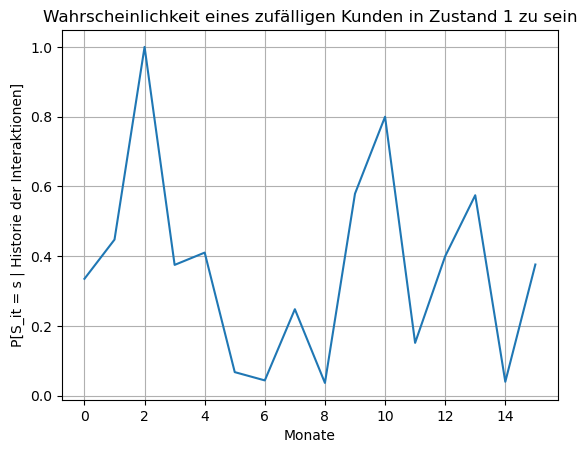

In [98]:
# Festes i
i = 2

# Werte für t generieren
t_values = range(anzahl_monate+1)

# Funktionswerte berechnen
funktionswerte = [p_it(i, t) for t in t_values]

# Plot erstellen
plt.plot(t_values, funktionswerte)
plt.xlabel('Monate')
plt.ylabel('P[S_it = s | Historie der Interaktionen]')
plt.title('Wahrscheinlichkeit eines zufälligen Kunden in Zustand 1 zu sein')
plt.grid(True)
plt.show()

#### Zufälliger Kunde i = 100

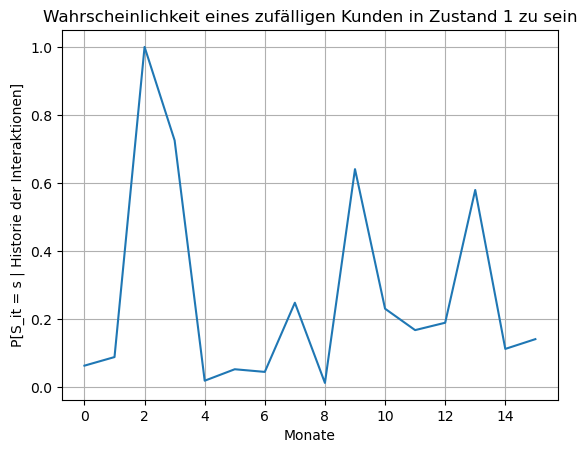

In [101]:
# Festes i
i = 100

# Werte für t generieren
t_values = range(anzahl_monate+1)

# Funktionswerte berechnen
funktionswerte = [p_it(i, t) for t in t_values]

# Plot erstellen
plt.plot(t_values, funktionswerte)
plt.xlabel('Monate')
plt.ylabel('P[S_it = s | Historie der Interaktionen]')
plt.title('Wahrscheinlichkeit eines zufälligen Kunden in Zustand 1 zu sein')
plt.grid(True)
plt.show()

#### Zufälliger Kunde i = 200

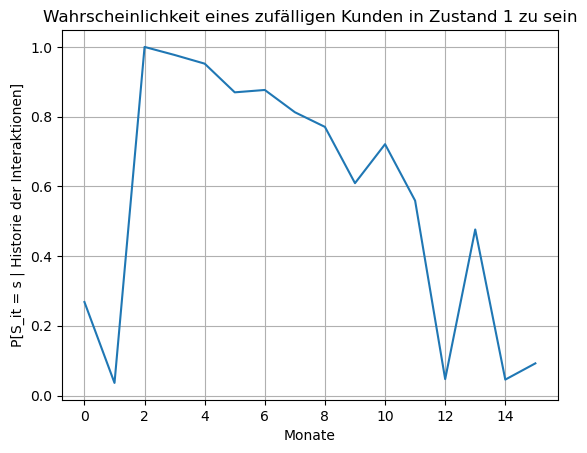

In [102]:
# Festes i
i = 200

# Werte für t generieren
t_values = range(anzahl_monate+1)

# Funktionswerte berechnen
funktionswerte = [p_it(i, t) for t in t_values]

# Plot erstellen
plt.plot(t_values, funktionswerte)
plt.xlabel('Monate')
plt.ylabel('P[S_it = s | Historie der Interaktionen]')
plt.title('Wahrscheinlichkeit eines zufälligen Kunden in Zustand 1 zu sein')
plt.grid(True)
plt.show()

#### Zufälliger Kunde i = 300

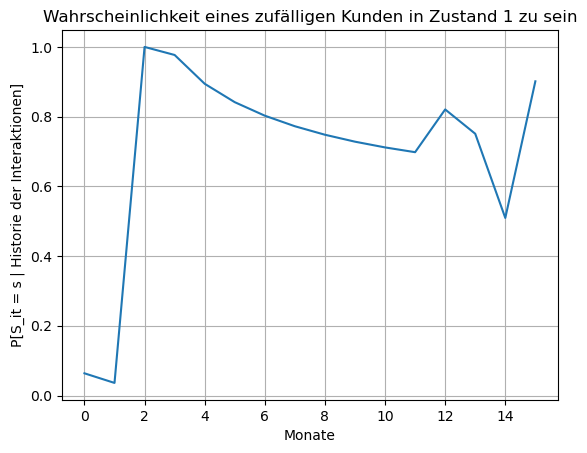

In [103]:
# Festes i
i = 300

# Werte für t generieren
t_values = range(anzahl_monate+1)

# Funktionswerte berechnen
funktionswerte = [p_it(i, t) for t in t_values]

# Plot erstellen
plt.plot(t_values, funktionswerte)
plt.xlabel('Monate')
plt.ylabel('P[S_it = s | Historie der Interaktionen]')
plt.title('Wahrscheinlichkeit eines zufälligen Kunden in Zustand 1 zu sein')
plt.grid(True)
plt.show()